In [424]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import cross_val_score
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

df = pd.read_csv('CR_COST_FC.csv', converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})
df['POD'] = pd.to_datetime(df['POD'])
df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
df = df.dropna(subset=['ENCODED_TYPE'])
df['RATE'] = df['RATE'].fillna(-1).astype(int)
df = df.dropna(subset=['RATE'])
df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)

# Remove NAN values
df_clean= df.dropna().reset_index(drop=True)

df_clean.head()
df_clean.info()
print(f'Dataset size: {df_clean.shape}')

,COM_ID,PARTY_ID,PARTY_ID_EN,PARTY_NAME,CSL_ID,ETA_ETD_NO,ETD_POL_D,POD_ID,POD,CNTR_ID,CNTR_SIZE,CNTR_TYPE,COST_TERM,RATE,ENCODED_TYPE,ENCODED_TERM,POD_ID_EN
0,010,010003678,10003678,OY TAVATUR SHIPPING LTD,ECS010060100191,20060228,FIHEL,HELSINKI,2006-02-28,CTNR010060201232,20,GP,FC,675,2,1,4.103561e+09
1,010,010004286,10004286,"GLOBELINK KOREA CO., LTD",ECS010060100465,20060303,KRPUS,BUSAN,2006-03-03,CTNR010060300014,40,HC,FC,390,1,1,2.904902e+09
2,010,01005136,1005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,ECS010060100321,20060227,NZAKL,AUCKLAND,2006-02-27,CTNR010060201198,40,HC NOR,FC,1615,4,1,2.397848e+09
3,010,01002775,1002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,ECS010060200201,20060306,AUADL,ADELAIDE,2006-03-06,CTNR010060300119,40,HC,FC,700,1,1,2.480737e+08
4,010,01001088,1001088,CARGO LINES S.A.-LE HAVRE,ECS010060200146,20060307,FRMRS,MARSEILLE,2006-03-07,CTNR010060300185,20,GP,FC,675,2,1,4.197227e+08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54083 entries, 0 to 54082
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   COM_ID        54083 non-null  object        
 1   PARTY_ID      54083 non-null  object        
 2   PARTY_ID_EN   54083 non-null  int64         
 3   PARTY_NAME    54083 non-null  object        
 4   CSL_ID        54083 non-null  object        
 5   ETA_ETD_NO    54083 non-null  int64         
 6   ETD_POL_D     54083 non-null  object        
 7   POD_ID        54083 non-null  object        
 8   POD           54083 non-null  datetime64[ns]
 9   CNTR_ID       54083 non-null  object        
 10  CNTR_SIZE     54083 non-null  object        
 11  CNTR_TYPE     54083 non-null  object        
 12  COST_TERM     54083 non-null  object        
 13  RATE          54083 non-null  int32         
 14  ENCODED_TYPE  54083 non-null  int32         
 15  ENCODED_TERM  54083 non-null  int64 

In [425]:
df_clean['CNTR_SIZE'] = df_clean['CNTR_SIZE'].astype(np.int32)
df_clean['RATE'] = df_clean['RATE'].astype(np.int32)
df_clean['PARTY_ID_EN'] = df_clean['PARTY_ID_EN'].astype(np.int32)
df_clean['POD_ID_EN'] = df_clean['POD_ID_EN'].astype(np.int64)
df_clean['ETA_ETD_NO'] = df_clean['ETA_ETD_NO'].astype(np.int32)
df_clean.info()
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54083 entries, 0 to 54082
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   COM_ID        54083 non-null  object        
 1   PARTY_ID      54083 non-null  object        
 2   PARTY_ID_EN   54083 non-null  int32         
 3   PARTY_NAME    54083 non-null  object        
 4   CSL_ID        54083 non-null  object        
 5   ETA_ETD_NO    54083 non-null  int32         
 6   ETD_POL_D     54083 non-null  object        
 7   POD_ID        54083 non-null  object        
 8   POD           54083 non-null  datetime64[ns]
 9   CNTR_ID       54083 non-null  object        
 10  CNTR_SIZE     54083 non-null  int32         
 11  CNTR_TYPE     54083 non-null  object        
 12  COST_TERM     54083 non-null  object        
 13  RATE          54083 non-null  int32         
 14  ENCODED_TYPE  54083 non-null  int32         
 15  ENCODED_TERM  54083 non-null  int64 

,COM_ID,PARTY_ID,PARTY_ID_EN,PARTY_NAME,CSL_ID,ETA_ETD_NO,ETD_POL_D,POD_ID,POD,CNTR_ID,CNTR_SIZE,CNTR_TYPE,COST_TERM,RATE,ENCODED_TYPE,ENCODED_TERM,POD_ID_EN
0,010,010003678,10003678,OY TAVATUR SHIPPING LTD,ECS010060100191,20060228,FIHEL,HELSINKI,2006-02-28,CTNR010060201232,20,GP,FC,675,2,1,4103561210
1,010,010004286,10004286,"GLOBELINK KOREA CO., LTD",ECS010060100465,20060303,KRPUS,BUSAN,2006-03-03,CTNR010060300014,40,HC,FC,390,1,1,2904901796
2,010,01005136,1005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,ECS010060100321,20060227,NZAKL,AUCKLAND,2006-02-27,CTNR010060201198,40,HC NOR,FC,1615,4,1,2397847664
3,010,01002775,1002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,ECS010060200201,20060306,AUADL,ADELAIDE,2006-03-06,CTNR010060300119,40,HC,FC,700,1,1,248073716
4,010,01001088,1001088,CARGO LINES S.A.-LE HAVRE,ECS010060200146,20060307,FRMRS,MARSEILLE,2006-03-07,CTNR010060300185,20,GP,FC,675,2,1,419722670


In [426]:
sel_col = ['COM_ID','CSL_ID', 'CNTR_ID','ENCODED_TERM','COST_TERM','POD_ID','ETD_POL_D','PARTY_ID',
           'PARTY_ID_EN', 'PARTY_NAME','POD_ID_EN','ETA_ETD_NO','POD',
           'CNTR_SIZE','ENCODED_TYPE','CNTR_TYPE','RATE']

df_fc = df_clean[sel_col]
df_fc.head()
df_fc.info()

,COM_ID,CSL_ID,CNTR_ID,ENCODED_TERM,COST_TERM,POD_ID,ETD_POL_D,PARTY_ID,PARTY_ID_EN,PARTY_NAME,POD_ID_EN,ETA_ETD_NO,POD,CNTR_SIZE,ENCODED_TYPE,CNTR_TYPE,RATE
0,010,ECS010060100191,CTNR010060201232,1,FC,HELSINKI,FIHEL,010003678,10003678,OY TAVATUR SHIPPING LTD,4103561210,20060228,2006-02-28,20,2,GP,675
1,010,ECS010060100465,CTNR010060300014,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20060303,2006-03-03,40,1,HC,390
2,010,ECS010060100321,CTNR010060201198,1,FC,AUCKLAND,NZAKL,01005136,1005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2397847664,20060227,2006-02-27,40,4,HC NOR,1615
3,010,ECS010060200201,CTNR010060300119,1,FC,ADELAIDE,AUADL,01002775,1002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,248073716,20060306,2006-03-06,40,1,HC,700
4,010,ECS010060200146,CTNR010060300185,1,FC,MARSEILLE,FRMRS,01001088,1001088,CARGO LINES S.A.-LE HAVRE,419722670,20060307,2006-03-07,20,2,GP,675


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54083 entries, 0 to 54082
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   COM_ID        54083 non-null  object        
 1   CSL_ID        54083 non-null  object        
 2   CNTR_ID       54083 non-null  object        
 3   ENCODED_TERM  54083 non-null  int64         
 4   COST_TERM     54083 non-null  object        
 5   POD_ID        54083 non-null  object        
 6   ETD_POL_D     54083 non-null  object        
 7   PARTY_ID      54083 non-null  object        
 8   PARTY_ID_EN   54083 non-null  int32         
 9   PARTY_NAME    54083 non-null  object        
 10  POD_ID_EN     54083 non-null  int64         
 11  ETA_ETD_NO    54083 non-null  int32         
 12  POD           54083 non-null  datetime64[ns]
 13  CNTR_SIZE     54083 non-null  int32         
 14  ENCODED_TYPE  54083 non-null  int32         
 15  CNTR_TYPE     54083 non-null  object

In [427]:
# filter out rows where the year is 2002
df_filtered = df_fc[df_fc['POD'].dt.year != 2002]
df_filtered.head()
df_filtered.info()

# Checking if year 2002 is removed
df_filtered['POD'].dt.year.unique()

,COM_ID,CSL_ID,CNTR_ID,ENCODED_TERM,COST_TERM,POD_ID,ETD_POL_D,PARTY_ID,PARTY_ID_EN,PARTY_NAME,POD_ID_EN,ETA_ETD_NO,POD,CNTR_SIZE,ENCODED_TYPE,CNTR_TYPE,RATE
0,010,ECS010060100191,CTNR010060201232,1,FC,HELSINKI,FIHEL,010003678,10003678,OY TAVATUR SHIPPING LTD,4103561210,20060228,2006-02-28,20,2,GP,675
1,010,ECS010060100465,CTNR010060300014,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20060303,2006-03-03,40,1,HC,390
2,010,ECS010060100321,CTNR010060201198,1,FC,AUCKLAND,NZAKL,01005136,1005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2397847664,20060227,2006-02-27,40,4,HC NOR,1615
3,010,ECS010060200201,CTNR010060300119,1,FC,ADELAIDE,AUADL,01002775,1002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,248073716,20060306,2006-03-06,40,1,HC,700
4,010,ECS010060200146,CTNR010060300185,1,FC,MARSEILLE,FRMRS,01001088,1001088,CARGO LINES S.A.-LE HAVRE,419722670,20060307,2006-03-07,20,2,GP,675


<class 'pandas.core.frame.DataFrame'>
Int64Index: 54082 entries, 0 to 54082
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   COM_ID        54082 non-null  object        
 1   CSL_ID        54082 non-null  object        
 2   CNTR_ID       54082 non-null  object        
 3   ENCODED_TERM  54082 non-null  int64         
 4   COST_TERM     54082 non-null  object        
 5   POD_ID        54082 non-null  object        
 6   ETD_POL_D     54082 non-null  object        
 7   PARTY_ID      54082 non-null  object        
 8   PARTY_ID_EN   54082 non-null  int32         
 9   PARTY_NAME    54082 non-null  object        
 10  POD_ID_EN     54082 non-null  int64         
 11  ETA_ETD_NO    54082 non-null  int32         
 12  POD           54082 non-null  datetime64[ns]
 13  CNTR_SIZE     54082 non-null  int32         
 14  ENCODED_TYPE  54082 non-null  int32         
 15  CNTR_TYPE     54082 non-null  object

array([2006, 2005, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2018, 2019, 2020, 2021, 2016, 2017, 2022, 2023], dtype=int64)

In [428]:
df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)
df_filtered.head()
df_filtered['POD'].dt.year.unique()

,COM_ID,CSL_ID,CNTR_ID,ENCODED_TERM,COST_TERM,POD_ID,ETD_POL_D,PARTY_ID,PARTY_ID_EN,PARTY_NAME,POD_ID_EN,ETA_ETD_NO,POD,CNTR_SIZE,ENCODED_TYPE,CNTR_TYPE,RATE
0,010,ECS01050600224,CTNR010050700354,1,FC,ROTTERDAM,NLRTM,01008827,1008827,YANG MING (SINGAPORE) PTE. LTD.,3241651053,20050715,2005-07-15,40,4,HC NOR,1620
1,010,ECS01050600610,CTNR010050700353,1,FC,FELIXSTOWE,GBFXT,01002303,1002303,GLOBELINK FALLOW LIMITED,941722266,20050715,2005-07-15,40,2,GP,1800
2,010,ECS01050600041,CTNR010050700351,1,FC,AUCKLAND,NZAKL,01005136,1005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2397847664,20050715,2005-07-15,40,4,HC NOR,2170
3,010,ECS01050600163,CTNR010050700370,1,FC,PASIR GUDANG,MYPGU,01002767,1002767,GLOBELINK CONTAINER LINES (JB) S/B,3870911506,20050715,2005-07-15,40,1,HC,280
4,010,ECS01050600456,CTNR010050700450,1,FC,KARACHI (KICT),PKKHI,01002783,1002783,GLOBELINK PAKISTAN (PVT) LTD,2209312015,20050716,2005-07-16,40,1,HC,1625


array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], dtype=int64)

<h4>FIltering and getting a list stored as a dictionary</h4>

In [429]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [430]:
filtered_dataframes = filter_dataframe(df_filtered)

In [431]:
df_ids = list(filtered_dataframes.keys())
print(list(df_ids))
print(len(list(df_ids)))

['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC N

For testing

In [432]:
# filtered_dataframes = filter_dataframe(df)
# top_3_keys = list(filtered_dataframes.keys())[:3]
# filtered_dataframes_subset = {key: filtered_dataframes[key] for key in top_3_keys}
# print(len(filtered_dataframes_subset))


In [433]:
# Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
key_row_counts = {key: len(filtered_dataframes[key]) for key in filtered_dataframes}

# Sort the key_row_counts dictionary by value (number of rows) in descending order
sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)
print(sorted_key_row_counts)

# Get the top 5 keys with the most rows
top_5_keys_tuple = sorted_key_row_counts[:5]
print(top_5_keys_tuple)

# Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
filtered_dataframes_subset = {}

for key, row_count in top_5_keys_tuple:
    filtered_dataframes_subset[key] = filtered_dataframes[key][:5]
    print(f"Number of rows in {key}: {row_count}")

print(filtered_dataframes_subset.keys())

[('Port_BUSAN_Size_40_Type_HC_PartyID_010004286', 1689), ('Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136', 1688), ('Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778', 1325), ('Port_SYDNEY_Size_40_Type_HC_PartyID_01002779', 1300), ('Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788', 1052), ('Port_HOCHIMINH CAT LAI,VIETNAM_Size_40_Type_HC_PartyID_010005256', 915), ('Port_AUCKLAND_Size_40_Type_HC NOR_PartyID_01005136', 865), ('Port_FREMANTLE_Size_40_Type_HC_PartyID_01002777', 814), ('Port_BRISBANE_Size_40_Type_HC_PartyID_01002776', 799), ('Port_MANILA (NORTH HARBOUR)_Size_40_Type_HC_PartyID_010021727', 672), ('Port_NHAVA SHEVA_Size_40_Type_HC_PartyID_01002787', 666), ('Port_PORT LOUIS_Size_40_Type_HC_PartyID_010007778', 650), ('Port_HAIPHONG_Size_40_Type_HC_PartyID_010005255', 646), ('Port_MADRAS/CHENNAI_Size_40_Type_HC_PartyID_010006979', 593), ('Port_FELIXSTOWE_Size_40_Type_HC_PartyID_01002303', 558), ('Port_VALPARAISO_Size_40_Type_HC NOR_PartyID_010006350', 556), ('Port_PIRAEUS_

Testing key

In [434]:
# grouped_df = filtered_dataframes['Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136']
# grouped_df.head()
# grouped_df.info()

<h4>Training Isolation Forest with all historical data for anomaly</h4>

In [443]:
def train_and_evaluate_models(filtered_dataframes_subset):

    # Initialize a dictionary to store the trained models and their evaluation scores
    trained_models = {}
    scores = {}

    # Train an IsolationForest model on each dataframe and evaluate its performance using cross-validation
    for key, group in filtered_dataframes_subset.items():
        print(key)
        
        # Create an IsolationForest model
        model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

        # Evaluate the model using cross-validation
        n_splits = max(min([len(group)-1 for group in filtered_dataframes_subset.values()]), 2)
        if n_splits == 0:
            scores[key] = 0
            continue
        score = cross_val_score(model, group[['RATE']], cv=n_splits, scoring='roc_auc').mean()
        scores[key] = score

        # Fit the model to the dataframe
        model.fit(group[['RATE']])

        # Store the trained model
        trained_models[key] = model

    # Select the model with the highest evaluation score
    best_model_key = max(scores, key=scores.get)
    best_model = trained_models[best_model_key]
    print(best_model_key)

    # Return the best model
    return best_model_key, best_model


Cross-validation can be used for evaluating the performance of an Isolation Forest algorithm for anomaly detection, but it's not always the best option.

Isolation Forest is an unsupervised learning algorithm, which means that there are no labels available to evaluate its performance in a traditional supervised learning sense. In this case, cross-validation can be used to evaluate the stability of the algorithm and its ability to detect anomalies in new, unseen data.

However, cross-validation assumes that the data is independently and identically distributed (i.i.d.), which may not always be the case in practice, especially when dealing with time series data. In such cases, a more appropriate evaluation method may be to use a sliding window approach, where the model is trained on a fixed window of past data and evaluated on a sliding window of future data.

Another evaluation metric that can be used for Isolation Forest is the area under the Receiver Operating Characteristic (ROC) curve (AUC-ROC). AUC-ROC is a measure of how well the model can distinguish between normal and anomalous data points, and can be useful when evaluating the performance of anomaly detection algorithms.

In summary, while cross-validation can be useful for evaluating the performance of an Isolation Forest algorithm, it's not always the best option, and other evaluation metrics and methods should also be considered depending on the specific use case and data characteristics.

In [444]:
best_model_key, best_model = train_and_evaluate_models(filtered_dataframes_subset)

Port_BUSAN_Size_40_Type_HC_PartyID_010004286


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
TypeError: _score() missing 1 required positional argument: 'y'

  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = s

Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
TypeError: _score() missing 1 required positional argument: 'y'

  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = s

Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
TypeError: _score() missing 1 required positional argument: 'y'

  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = s

Port_SYDNEY_Size_40_Type_HC_PartyID_01002779


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
TypeError: _score() missing 1 required positional argument: 'y'

  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = s

Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
TypeError: _score() missing 1 required positional argument: 'y'

  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = s

Port_BUSAN_Size_40_Type_HC_PartyID_010004286


In [445]:
print(best_model_key)
df_best_key = filtered_dataframes[best_model_key]
df_best_key.head()
df_best_key.info()

Port_BUSAN_Size_40_Type_HC_PartyID_010004286


,COM_ID,CSL_ID,CNTR_ID,ENCODED_TERM,COST_TERM,POD_ID,ETD_POL_D,PARTY_ID,PARTY_ID_EN,PARTY_NAME,POD_ID_EN,ETA_ETD_NO,POD,CNTR_SIZE,ENCODED_TYPE,CNTR_TYPE,RATE,ANOMALY
0,010,ECS010050800407,CTNR010050901151,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20051003,2005-10-03,40,1,HC,390,1
1,010,ECS010050800407,CTNR010050901379,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20051003,2005-10-03,40,1,HC,390,1
2,010,ECS010050900468,CTNR010051000081,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20051007,2005-10-07,40,1,HC,390,1
3,010,ECS010050900468,CTNR010050901461,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20051007,2005-10-07,40,1,HC,390,1
4,010,ECS010050900469,CTNR010051000434,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20051014,2005-10-14,40,1,HC,390,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 0 to 1688
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   COM_ID        1689 non-null   object        
 1   CSL_ID        1689 non-null   object        
 2   CNTR_ID       1689 non-null   object        
 3   ENCODED_TERM  1689 non-null   int64         
 4   COST_TERM     1689 non-null   object        
 5   POD_ID        1689 non-null   object        
 6   ETD_POL_D     1689 non-null   object        
 7   PARTY_ID      1689 non-null   object        
 8   PARTY_ID_EN   1689 non-null   int32         
 9   PARTY_NAME    1689 non-null   object        
 10  POD_ID_EN     1689 non-null   int64         
 11  ETA_ETD_NO    1689 non-null   int32         
 12  POD           1689 non-null   datetime64[ns]
 13  CNTR_SIZE     1689 non-null   int32         
 14  ENCODED_TYPE  1689 non-null   int32         
 15  CNTR_TYPE     1689 non-null   object  

IsolationForest(random_state=42)

,COM_ID,CSL_ID,CNTR_ID,ENCODED_TERM,COST_TERM,POD_ID,ETD_POL_D,PARTY_ID,PARTY_ID_EN,PARTY_NAME,POD_ID_EN,ETA_ETD_NO,POD,CNTR_SIZE,ENCODED_TYPE,CNTR_TYPE,RATE,ANOMALY
0,010,ECS010050800407,CTNR010050901151,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20051003,2005-10-03,40,1,HC,390,-1
1,010,ECS010050800407,CTNR010050901379,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20051003,2005-10-03,40,1,HC,390,-1
2,010,ECS010050900468,CTNR010051000081,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20051007,2005-10-07,40,1,HC,390,-1
3,010,ECS010050900468,CTNR010050901461,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20051007,2005-10-07,40,1,HC,390,-1
4,010,ECS010050900469,CTNR010051000434,1,FC,BUSAN,KRPUS,010004286,10004286,"GLOBELINK KOREA CO., LTD",2904901796,20051014,2005-10-14,40,1,HC,390,-1


Text(0.5, 0, 'Date')

Text(0, 0.5, 'Rate')

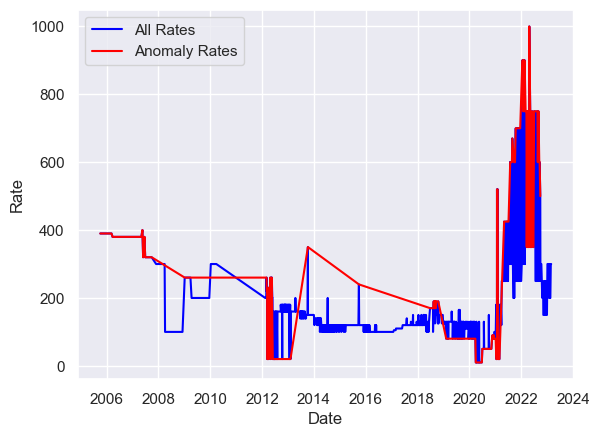

      COM_ID   PARTY_ID  PARTY_ID_EN  \
0        010  010003678     10003678   
1        010  010004286     10004286   
2        010   01005136      1005136   
3        010   01002775      1002775   
4        010   01001088      1001088   
...      ...        ...          ...   
54084    010  010021735     10021735   
54085    010   01002779      1002779   
54086    010  010006487     10006487   
54087    010  010007778     10007778   
54088    010   01002787      1002787   

                                       PARTY_NAME           CSL_ID  \
0                         OY TAVATUR SHIPPING LTD  ECS010060100191   
1                        GLOBELINK KOREA CO., LTD  ECS010060100465   
2      MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND  ECS010060100321   
3        GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE  ECS010060200201   
4                       CARGO LINES S.A.-LE HAVRE  ECS010060200146   
...                                           ...              ...   
54084           GLOBELINK NVO

In [447]:
# Train the algorithm
best_model.fit(df_best_key[['RATE']])

# Predict anomalies
df_best_key['ANOMALY'] = best_model.predict(df_best_key[['RATE']])
# df_best_key.head()

# Create a new dataframe for the anomalies
is_anomaly = df_best_key[df_best_key['ANOMALY']== -1].reset_index(drop=True)
is_anomaly.head()

# Plot the data
plt.plot(df_best_key['POD'], df_best_key['RATE'],
         color='blue', label='All Rates')
plt.plot(is_anomaly['POD'], is_anomaly['RATE'],
         color='red', label='Anomaly Rates')

# Add axis labels and legend
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()

# Show the plot
plt.show()

# Print values
print(df)
print(is_anomaly)